### Técnicas de Classificação para os datasets do BrainMask

In [2]:
# Confirmar a instalação

import torch
print(torch.__version__)

2.2.2


### Imports

In [3]:
# pytorch mlp for binary classification
import time
import pandas as pd
import numpy as np
import ast

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import BCELoss, BCEWithLogitsLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

#from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV


import random
import os
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


set_seed(24)

Random seed set as 24


In [4]:
#####ir buscar o dataset:
#!wget -c https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv -O ionosphere.csv

In [5]:
#Constants

PATH = './'
PATH_1 = '/Users/inesfaria/Desktop/Universidade/Informática Médica/4º/2º Semestre/Imagiologia/Trabalho_IMG/dataset_syntatic_class/dados_reais/CSV1_UC_brainMask_clean.csv'
PATH_2 = '/Users/inesfaria/Desktop/Universidade/Informática Médica/4º/2º Semestre/Imagiologia/Trabalho_IMG/dataset_syntatic_class/dados_sinteticos/CSV0_UC_brainMask_clean.csv'

#setting device on GPU if available, else CPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Additional Info when using cuda
#if device.type == 'cuda':
    #print(torch.cuda.get_device_name(0))
    #print('Memory Usage:')
    #print('global free:', round(torch.cuda.mem_get_info()[0]/1024**3,1), 'GB')
    #print('global total:', round(torch.cuda.mem_get_info()[1]/1024**3,1), 'GB')
    #print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    #print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')



#force cpu
device = torch.device("cpu")
print('Using device:', device)
print()


EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

Using device: cpu



### 1. Preparar os Dados

In [6]:
#buscar o dataset utilizando os CSVs e uma classe para o dataset

# definição classe para o dataset
class CSVDataset(Dataset):
    # ler o dataset
    def __init__(self, path_1, path_2):
        # ler o ficheiro csv para um dataframe
        df_1 = pd.read_csv(path_1, header=0)
        df_2 = pd.read_csv(path_2, header=0)

        y_1 = df_1.values[:, 0]
        y_2 = df_2.values[:, 0]
        self.y = np.concatenate([y_1, y_2], axis=0)
        
        for i in range(len(self.y)):
            if self.y[i].startswith('synt_'):
                self.y[i] = 0
            else:
                self.y[i] = 1
    
        self.y = self.y.astype('long')
        
        # Aplicar a conversão
        df_1 = self.convert_strings_to_floats(df_1)
        df_2 = self.convert_strings_to_floats(df_2)

        [x_1, x_2] = self.filter_datasets([df_1.iloc[:, 1:], df_2.iloc[:, 1:]])
        x_1_columns = x_1.columns.astype('str')
        x_1 = x_1.values.astype('float32')
        x_2_columns = x_2.columns.astype('str')
        x_2 = x_2.values.astype('float32')

        self.x = np.concatenate([x_1, x_2], axis=0)
        self.x_columns = np.concatenate([x_1_columns, x_2_columns], axis=0)
        
    # numero de casos de treino no dataset
    def __len_1__(self):
        return len(self.x_1)
     # numero de casos de teste no dataset
    def __len_2__(self):
        return len(self.x_2)
    
    # retornar um caso
    def __getitem_1__(self, idx):
        return [self.x_1[idx], self.y_1[idx]]
     # retornar um caso
    def __getitem_2__(self, idx):
        return [self.x_2[idx], self.y_2[idx]]
    
    # Função para converter strings em listas de floats
    def convert_strings_to_floats(self, df):
        for col in df.columns[1:]:
            df[col] = df[col].apply(lambda x: np.mean(ast.literal_eval(x)) if isinstance(x, str) else float(x))
        return df
    
    #A brainmask tem numero de colunas diferente de real para sintético,
    # então as diferenças têm de ser eliminadas ou não vai dar para comparar os dois
    def filter_datasets(self, datasets):
        # Get column sets for each dataset
        column_sets = [set(df.columns) for df in datasets]
        
        # Find the intersection of column sets
        common_cols = set.intersection(*column_sets)
        
        # Filter out non-common columns from each dataset
        filtered_datasets = [df[list(common_cols)] for df in datasets]
        
        return filtered_datasets
    
    # retornar indeces para casos de treino de de teste em formato flat (vetor)
    def get_splits(self):
        
        X_train, X_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.3, random_state=42)
    
        return X_train, X_test, y_train, y_test 

# preparar o dataset
def prepare_data_flat(path_1, path_2):
    # criar uma instancia do dataset
    dataset = CSVDataset(path_1, path_2)
    # calcular split
    X_train, X_test, y_train, y_test  = dataset.get_splits()
    # preparar data loaders
    return X_train, X_test, y_train, y_test, dataset.x_columns

# preparar os dados
x_train, x_test, y_train, y_test, x_columns = prepare_data_flat(PATH_1, PATH_2)

### 1.1 Visualizar os Dados

In [7]:
def output_label(label):
    output_mapping = { 0: "Sintético", 1: "Real"}
    output_mapping2 = { 0: "0", 1: "1"}
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [8]:
from IPython.display import display

def visualize_data(path):
    # criar uma instancia do dataset
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train, test):
    print(f"Quantidade de casos do dataset 1:{len(train)}") 
    print(f"Quantidade de casos do dataset 2:{len(test)}")
    print(y_train)

visualize_data(PATH_1)
visualize_dataset(x_train, x_test)

Volume  diagnostics_Image-original_Mean  \
0   BraTS-GLI-00062-000_0000.nii.gz                       408.994230   
1   BraTS-GLI-00061-000_0000.nii.gz                       464.226297   
2   BraTS-GLI-00014-001_0000.nii.gz                       138.141496   
3   BraTS-GLI-00058-001_0000.nii.gz                        75.857550   
4   BraTS-GLI-00033-000_0000.nii.gz                       449.711149   
5   BraTS-GLI-00046-000_0000.nii.gz                       508.515277   
6   BraTS-GLI-00006-000_0000.nii.gz                       365.708481   
7   BraTS-GLI-00048-001_0000.nii.gz                        75.035228   
8   BraTS-GLI-00031-000_0000.nii.gz                       453.536173   
9   BraTS-GLI-00035-000_0000.nii.gz                       267.790031   
10  BraTS-GLI-00048-000_0000.nii.gz                       571.634540   
11  BraTS-GLI-00061-001_0000.nii.gz                       336.144393   
12  BraTS-GLI-00024-001_0000.nii.gz                       360.538371   
13  BraTS-GLI-00056-000_0000.nii.gz                       350.499574   
14  BraTS-GLI-00058-000_0000.nii.gz                       333.388901   
15  BraTS-GLI-00016-001_0000.nii.gz                       255.500808   
16  BraTS-GLI-00022-000_0000.nii.gz                       354.999183   
17  BraTS-GLI-00009-001_0000.nii.gz                        88.779822   
18  BraTS-GLI-00021-000_0000.nii.gz                       371.459707   
19  BraTS-GLI-00059-000_0000.nii.gz                       361.860683   
20  BraTS-GLI-00024-000_0000.nii.gz                       507.561055   
21  BraTS-GLI-00009-000_0000.nii.gz                       216.201840   
22  BraTS-GLI-00053-000_0000.nii.gz                       569.938277   
23  BraTS-GLI-00008-001_0000.nii.gz                       666.479344   
24  BraTS-GLI-00043-000_0000.nii.gz                       221.587179   
25  BraTS-GLI-00014-000_0000.nii.gz                       393.416726   
26  BraTS-GLI-00059-001_0000.nii.gz                       141.309437   
27  BraTS-GLI-00053-001_0000.nii.gz                       273.006976   
28  BraTS-GLI-00054-000_0000.nii.gz                       446.279731   
29  BraTS-GLI-00036-000_0000.nii.gz                       555.537822   
30  BraTS-GLI-00017-000_0000.nii.gz                       371.494581   
31  BraTS-GLI-00030-000_0000.nii.gz                       443.159262   
32  BraTS-GLI-00028-000_0000.nii.gz                       328.405674   
33  BraTS-GLI-00021-001_0000.nii.gz                        88.919284   
34  BraTS-GLI-00016-000_0000.nii.gz                       345.218855   
35  BraTS-GLI-00056-001_0000.nii.gz                        57.197548   
36  BraTS-GLI-00019-000_0000.nii.gz                       408.609915   
37  BraTS-GLI-00011-000_0000.nii.gz                       304.360214   
38  BraTS-GLI-00020-000_0000.nii.gz                       463.025264   
39  BraTS-GLI-00022-001_0000.nii.gz                       144.669557   
40  BraTS-GLI-00051-000_0000.nii.gz                       371.279251   
41  BraTS-GLI-00026-000_0000.nii.gz                       519.899761   
42  BraTS-GLI-00002-000_0000.nii.gz                       296.808290   
43  BraTS-GLI-00031-001_0000.nii.gz                       153.731375   
44  BraTS-GLI-00052-000_0000.nii.gz                       312.696959   
45  BraTS-GLI-00000-000_0000.nii.gz                       345.505903   
46  BraTS-GLI-00032-001_0000.nii.gz                       118.274479   
47  BraTS-GLI-00025-000_0000.nii.gz                       513.209112   
48  BraTS-GLI-00044-000_0000.nii.gz                       445.258949   
49  BraTS-GLI-00005-000_0000.nii.gz                       288.648615   

    diagnostics_Image-original_Minimum  diagnostics_Image-original_Maximum  \
0                             0.000000                        16176.000000   
1                             0.000000                        14274.000000   
2                             0.000000                         2435.395996   
3                             0.000000      

Quantidade de casos do dataset 1:70
Quantidade de casos do dataset 2:30
[1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1
 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0]


### 1.2 Verificar balanceamento do dataset

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def visualize_holdout_balance(train, test):
    # Configurar o estilo do seaborn
    sns.set_style('whitegrid')

    # Calcular o número de casos de treino e teste
    casos_treino = len(train)
    casos_test = len(test)

    # Exibir as informações calculadas
    print("casos_treino:", casos_treino)
    print("casos_test:", casos_test)

    # Criar o gráfico de barras para visualizar o balanceamento dos dados
    grafico = sns.barplot(x=['casos_treino', 'casos_test'], 
                          y=[casos_treino, casos_test])
    grafico.set_title('Data Balance')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

#Exemplo de chamada da função
visualize_holdout_balance(x_train, x_test)


casos_treino: 70
casos_test: 30


### 2. Técnicas de Classificação 

In [10]:
def display_confusion_matrix (cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def avaliar_modelo (model, x_test, y_test):
    # Predict and evaluate
    y_pred = model.predict(x_test)
    cr = classification_report(y_test, y_pred, output_dict=True)
    display(cr)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy =', accuracy)
    list_classes=[output_label(int(n)) for n in list(cr.keys())[0:2] ]
    display_confusion_matrix(confusion_matrix(y_test, y_pred), list_classes)

def display_features (model, x_columns):
    
    # Feature importance using Random Forest
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Selecionar as top features
    num_top_features = 30
    top_features = x_columns[indices[:num_top_features]]
    
    # Plot das top features
    plt.figure(figsize=(10, 8))
    plt.title("Top 30 Features Importances")
    plt.barh(range(num_top_features), importances[indices[:num_top_features]], align='center')
    plt.yticks(range(num_top_features), top_features)
    plt.gca().invert_yaxis()
    plt.xlabel("Relative Importance")
    plt.show()
    
    return indices[:num_top_features]

Random Forest

In [11]:
# Random Forest

# Train the model
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(x_train, y_train)

# Evaluate the model
avaliar_modelo(model1, x_test, y_test)
top_features = display_features(model1, x_columns)

# Step 7: Treino do Modelo de Classificação usando as Top Features
# Selecionar as top features para o conjunto de treino e teste
X_train_top = x_train[:, top_features]
X_test_top = x_test[:, top_features]

# Treinar um modelo de classificação usando as top features
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_top, y_train)

# Evaluate the model
avaliar_modelo(classifier, X_test_top, y_test)
    

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0}}

Accuracy = 1.0


{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0}}

Accuracy = 1.0


Gradient Boosting Forest

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0}}

Accuracy = 1.0


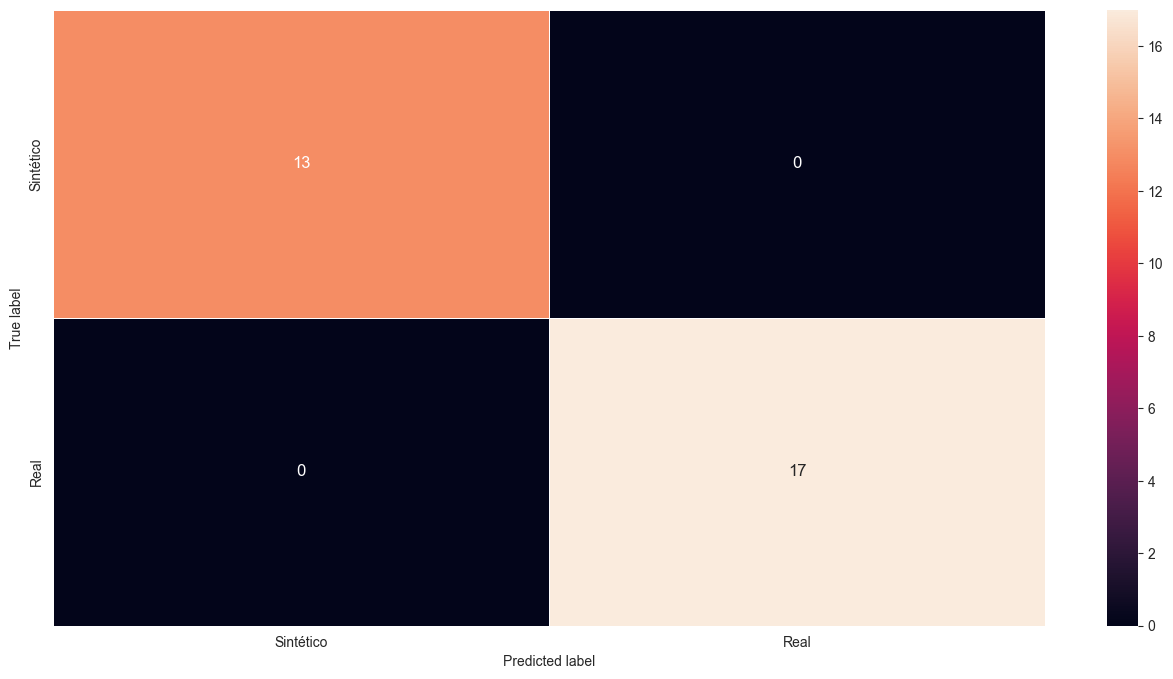

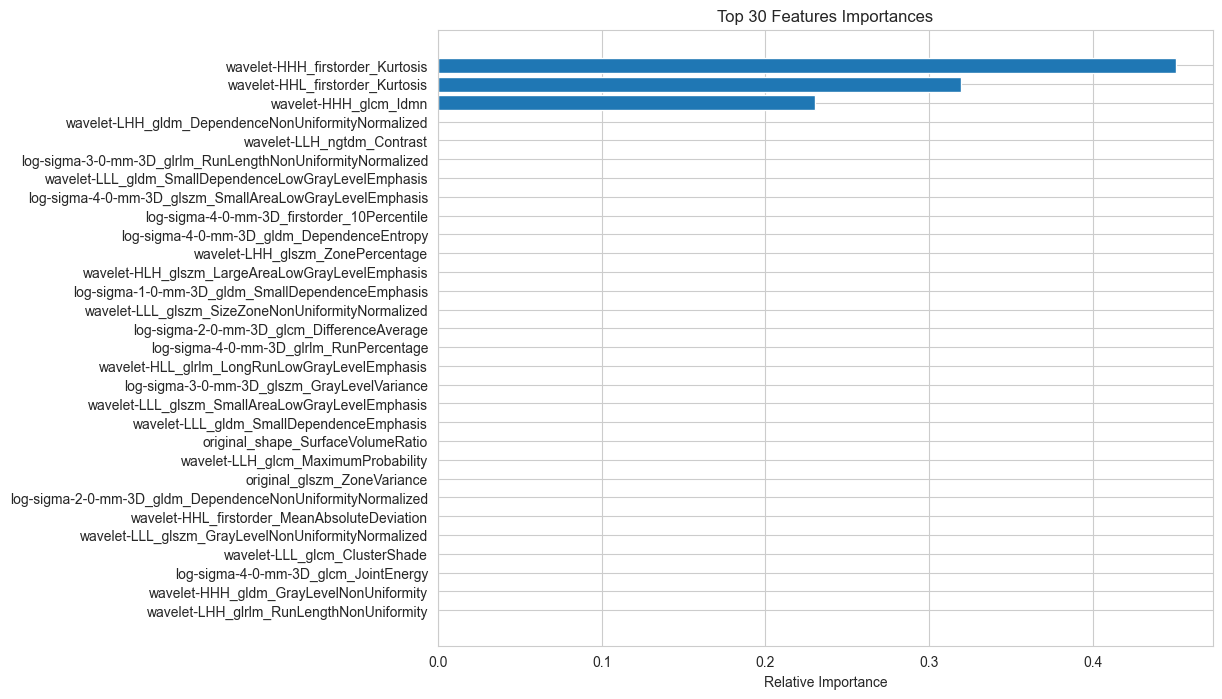

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0}}

Accuracy = 1.0


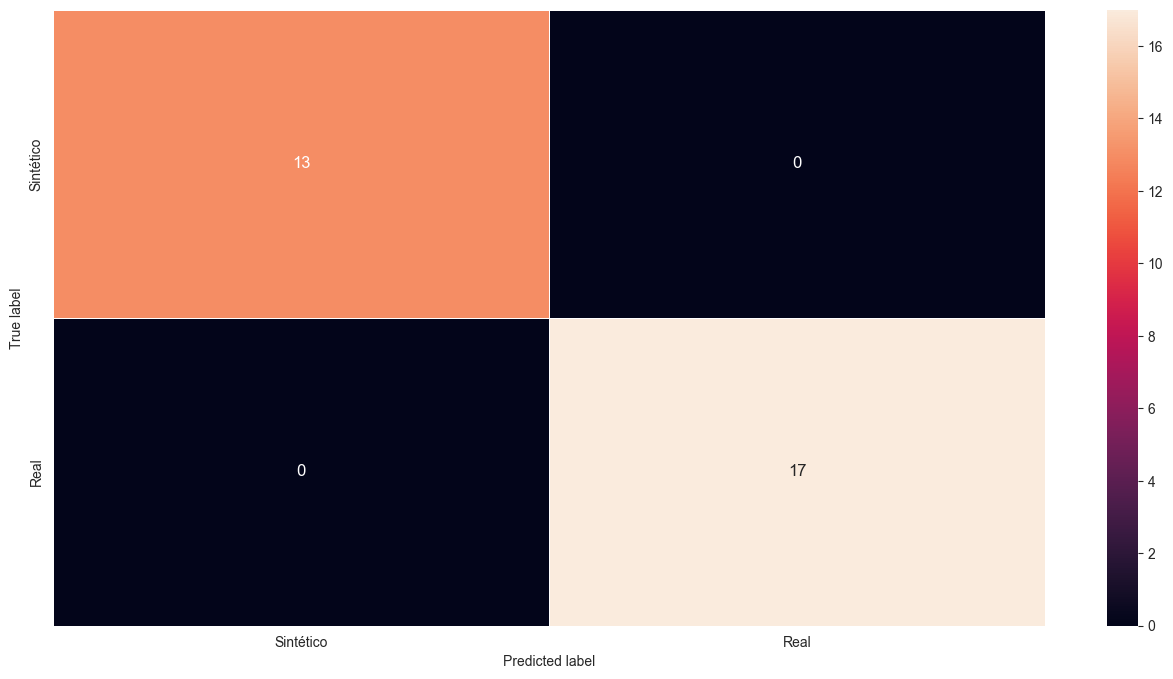

In [12]:
# Gradient Boosting Forest

# Train the model
model2 = GradientBoostingClassifier(n_estimators=100, random_state=42)
model2.fit(x_train, y_train)

# Evaluate the model
avaliar_modelo(model2, x_test, y_test)
top_features = display_features(model2, x_columns)

# Step 7: Treino do Modelo de Classificação usando as Top Features
# Selecionar as top features para o conjunto de treino e teste
X_train_top = x_train[:, top_features]
X_test_top = x_test[:, top_features]

# Treinar um modelo de classificação (Random Forest) usando as top features
classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_top, y_train)

# Evaluate the model
avaliar_modelo(classifier, X_test_top, y_test)

Decision Tree Classifier

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0}}

Accuracy = 1.0


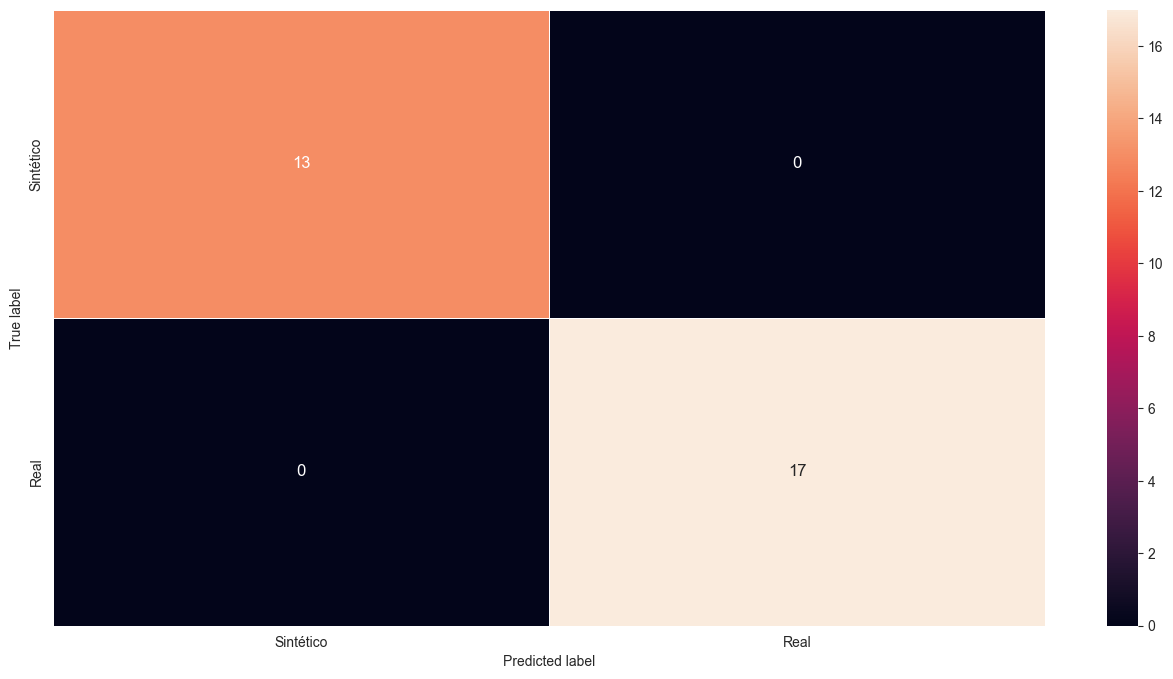

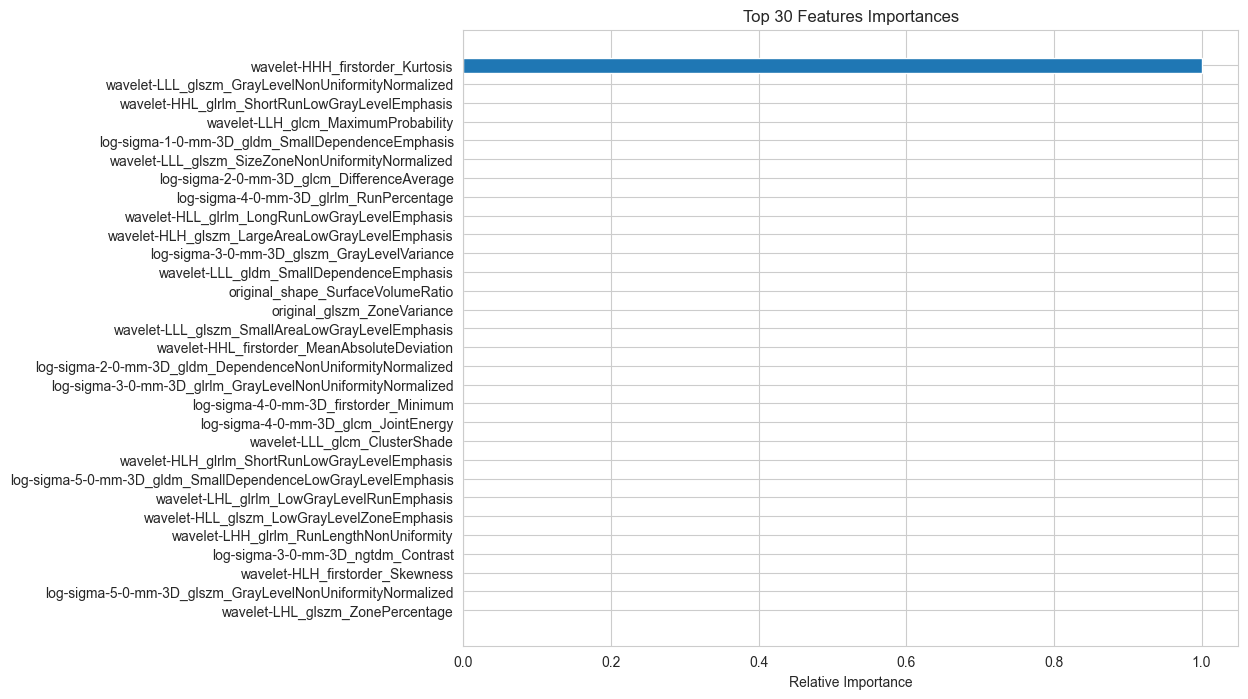

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 30.0}}

Accuracy = 1.0


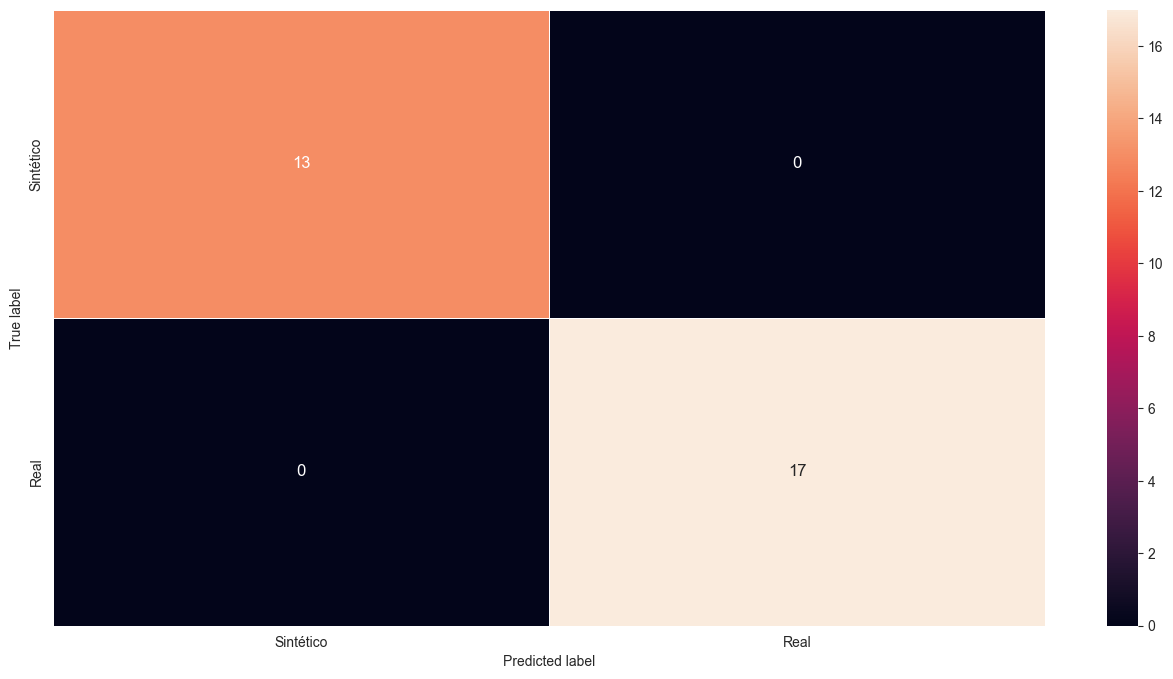

In [13]:
# Train the model
from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier()
model2.fit(x_train, y_train)

# Evaluate the model
avaliar_modelo(model2, x_test, y_test)
top_features = display_features(model2, x_columns)

# Step 7: Treino do Modelo de Classificação usando as Top Features
# Selecionar as top features para o conjunto de treinamento e teste
X_train_top = x_train[:, top_features]
X_test_top = x_test[:, top_features]

# Treinar um modelo de classificação usando as top features
classifier = DecisionTreeClassifier()
classifier.fit(X_train_top, y_train)

# Evaluate the model
avaliar_modelo(classifier, X_test_top, y_test)

Logistic Regression

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


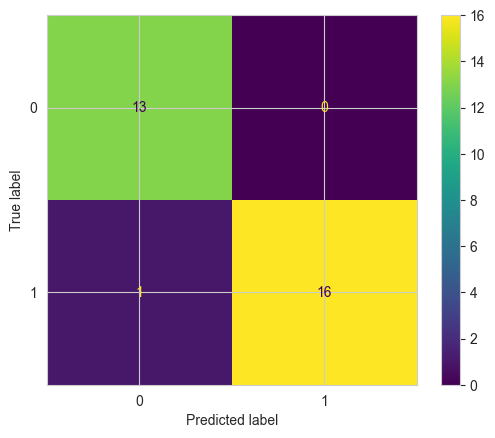

Accuracy: 0.9666666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.94      0.97        17

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [14]:
# Train the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

logistic_model = LogisticRegression()

# Treinar o modelo
logistic_model.fit(x_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = logistic_model.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

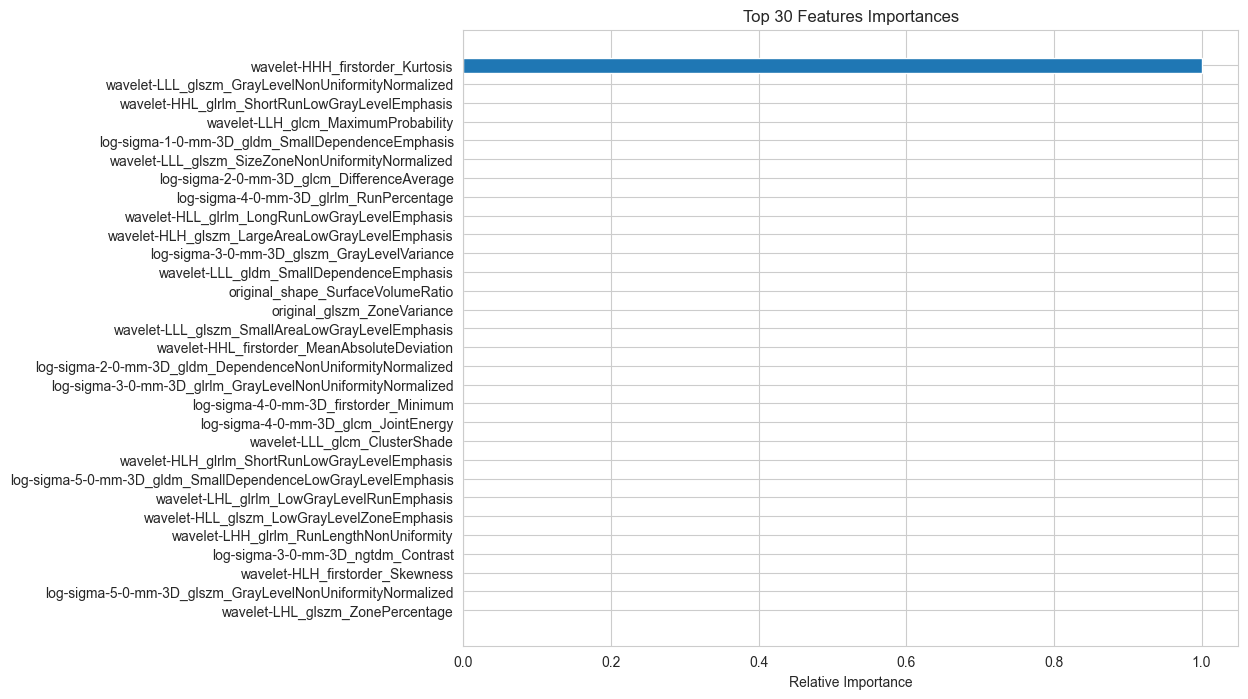

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'0': {'precision': 0.8666666666666667,
  'recall': 1.0,
  'f1-score': 0.9285714285714286,
  'support': 13.0},
 '1': {'precision': 1.0,
  'recall': 0.8823529411764706,
  'f1-score': 0.9375,
  'support': 17.0},
 'accuracy': 0.9333333333333333,
 'macro avg': {'precision': 0.9333333333333333,
  'recall': 0.9411764705882353,
  'f1-score': 0.9330357142857143,
  'support': 30.0},
 'weighted avg': {'precision': 0.9422222222222222,
  'recall': 0.9333333333333333,
  'f1-score': 0.9336309523809523,
  'support': 30.0}}

Accuracy = 0.9333333333333333


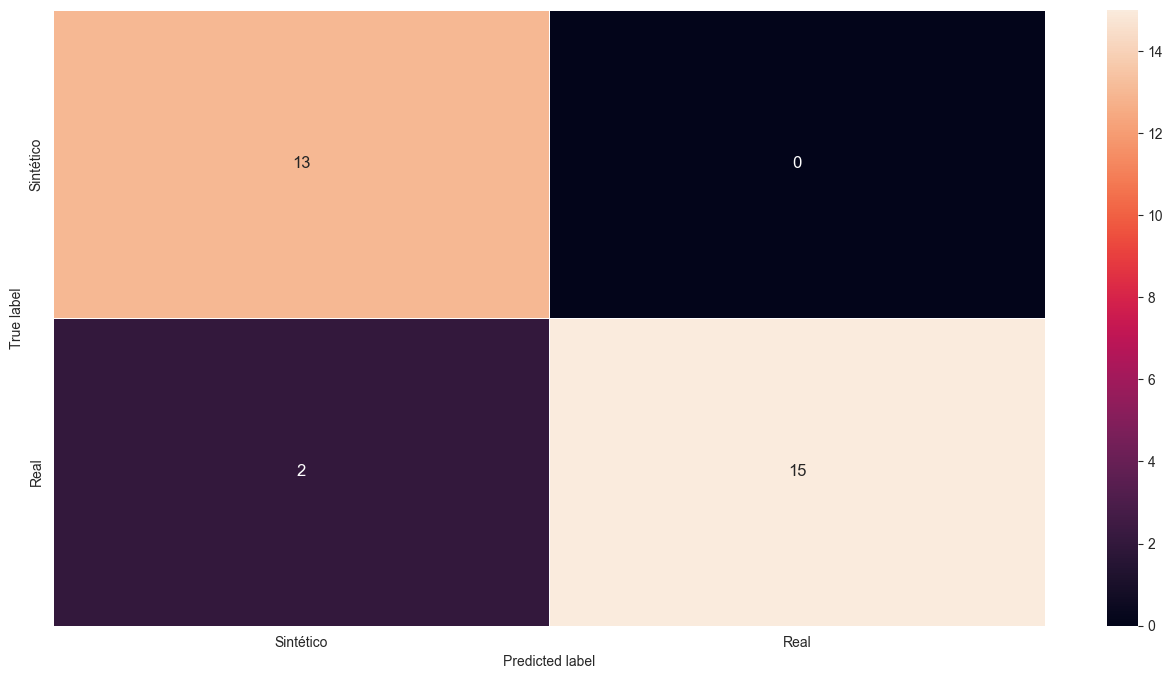

In [15]:
top_features = display_features(model2, x_columns)
# Selecionar as top features para o conjunto de treinamento e teste
X_train_top = x_train[:, top_features]
X_test_top = x_test[:, top_features]

# Treinar um modelo de classificação usando as top features
classifier = LogisticRegression()
classifier.fit(X_train_top, y_train)

# Evaluate the model
avaliar_modelo(classifier, X_test_top, y_test)